In [33]:
import math
import pandas as pd
import matplotlib.pyplot as plt

from rouge import Rouge

from datasets import load_dataset
from transformers import BartTokenizer, BartForConditionalGeneration

In [34]:
dataset = load_dataset('cnn_dailymail', '3.0.0')
data = dataset['test']
data_df = pd.DataFrame(data).head(100)

Found cached dataset cnn_dailymail (C:/Users/vijay/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

In [35]:
data_df['article_length'] = data_df['article'].apply(lambda x: len(x))

In [36]:
data_df['summary_length'] = data_df['article'].apply(lambda x: math.ceil(len(x)/10))

In [37]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

In [38]:
def get_summary(row):
    
    input_text = row['article']
    max_length = row['summary_length']
    
    
    inputs = tokenizer(input_text, truncation=True, padding="longest", max_length=1024, return_tensors="pt")
    summary_ids = model.generate(inputs["input_ids"], num_beams=4, max_length=max_length, early_stopping=True)
    
    print(tokenizer.decode(summary_ids[0], skip_special_tokens=True))
    
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [39]:
data_df['summary'] = data_df.apply(lambda row: get_summary(row), axis=1)

The Palestinian Authority becomes the 123rd member of the International Criminal Court. The move gives the court jurisdiction over alleged crimes in Palestinian territories. Israel and the United States opposed the Palestinians' efforts to join the body. But Palestinian Foreign Minister Riad al-Malki said it was a move toward greater justice.
Theia, a one-year-old bully breed mix, was hit by a car and buried in a field. Four days after her apparent death, the dog managed to stagger to a nearby farm. She suffered a dislocated jaw, leg injuries and a caved-in sinus cavity. She still requires surgery to help her breathe.
Mohammad Javad Zarif is the Iranian foreign minister. He has been John Kerry's opposite number in securing a breakthrough in nuclear discussions. He received a hero's welcome as he arrived in Iran on a sunny Friday morning. But there are some facts about Zarif that are less well-known.
The five were exposed to Ebola in Sierra Leone in March, but none developed the deadly 

In [40]:
rouge = Rouge()

data_df['rouge_scores'] = data_df.apply(lambda row: rouge.get_scores(row['summary'], row['highlights']), axis=1)

In [41]:
rouge_scores = data_df['rouge_scores']

rouge_1 = {'r': 0, 'p': 0, 'f': 0}
rouge_2 = {'r': 0, 'p': 0, 'f': 0}
rouge_l = {'r': 0, 'p': 0, 'f': 0}

for scores in rouge_scores:
    rouge_1_scores = scores[0]['rouge-1']
    rouge_2_scores = scores[0]['rouge-2']
    rouge_l_scores = scores[0]['rouge-l']

    rouge_1['r'] += rouge_1_scores['r']
    rouge_1['p'] += rouge_1_scores['p']
    rouge_1['f'] += rouge_1_scores['f']

    rouge_2['r'] += rouge_2_scores['r']
    rouge_2['p'] += rouge_2_scores['p']
    rouge_2['f'] += rouge_2_scores['f']

    rouge_l['r'] += rouge_l_scores['r']
    rouge_l['p'] += rouge_l_scores['p']
    rouge_l['f'] += rouge_l_scores['f']

num_rows = len(rouge_scores)

rouge_1_avg = {'recall': rouge_1['r'] / num_rows, 'precision': rouge_1['p'] / num_rows, 'f1-score': rouge_1['f'] / num_rows}
rouge_2_avg = {'recall': rouge_2['r'] / num_rows, 'precision': rouge_2['p'] / num_rows, 'f1-score': rouge_2['f'] / num_rows}
rouge_l_avg = {'recall': rouge_l['r'] / num_rows, 'precision': rouge_l['p'] / num_rows, 'f1-score': rouge_l['f'] / num_rows}

average_scores = pd.DataFrame({'ROUGE-1': rouge_1_avg, 'ROUGE-2': rouge_2_avg, 'ROUGE-L': rouge_l_avg})

average_scores

,ROUGE-1,ROUGE-2,ROUGE-L
recall,0.398184,0.174909,0.372049
precision,0.258110,0.102601,0.239938
f1-score,0.308632,0.126857,0.287446


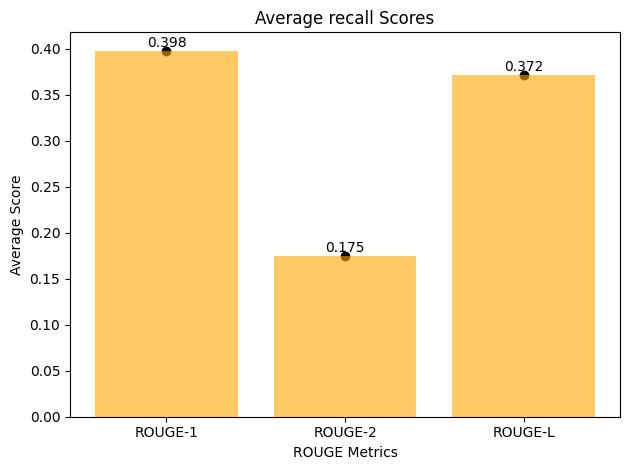

In [42]:
x_values = average_scores.columns
y_values = average_scores.loc['recall']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average recall Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

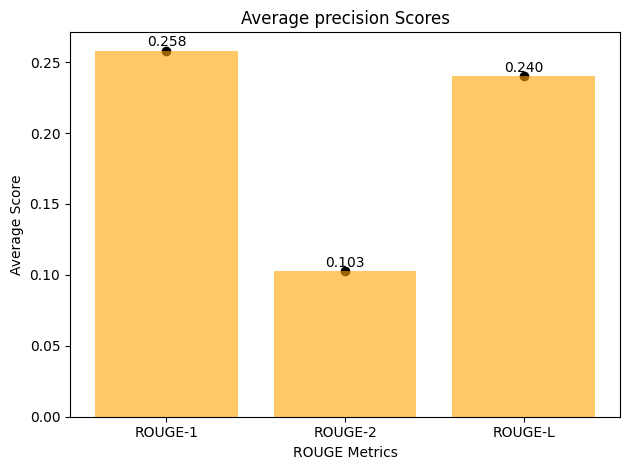

In [43]:
x_values = average_scores.columns
y_values = average_scores.loc['precision']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average precision Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

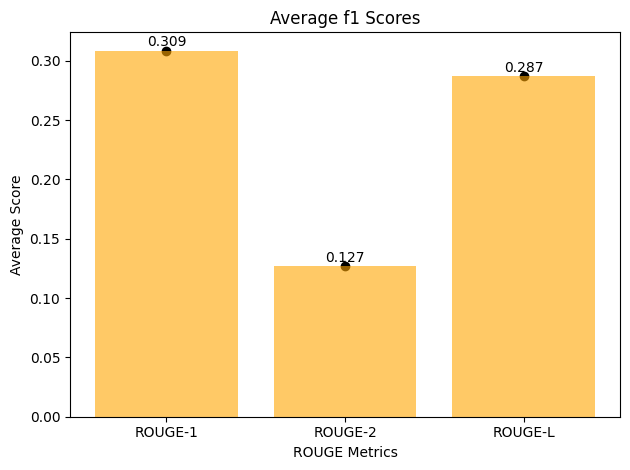

In [44]:
x_values = average_scores.columns
y_values = average_scores.loc['f1-score']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average f1 Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

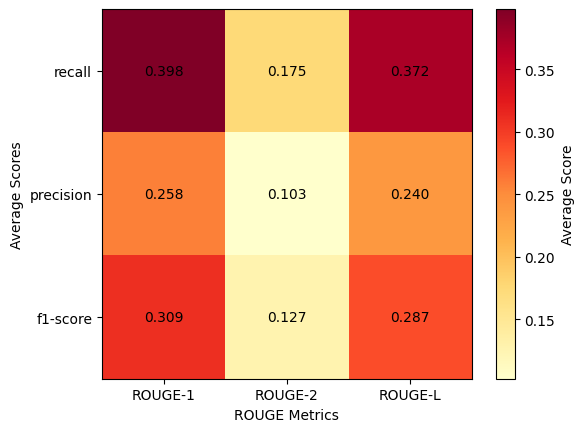

In [45]:
plt.imshow(average_scores, cmap='YlOrRd')

plt.xticks(range(len(average_scores.columns)), average_scores.columns)
plt.yticks(range(len(average_scores.index)), average_scores.index)
plt.xlabel('ROUGE Metrics')
plt.ylabel('Average Scores')

for i in range(len(average_scores.index)):
    for j in range(len(average_scores.columns)):
        plt.text(j, i, f'{average_scores.iloc[i, j]:.3f}', ha='center', va='center', color='black')

plt.colorbar(label='Average Score')

plt.show()